### House Prices Competition

This will be my first entry to a Kaggle competition. I am pretty excited.

First thing to do is import all the libraries that I might need for a tabular regression problem.

#hide
import fastai
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
#import dtreeviz
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

### 1. Download Data

Next is to download kaggle's House Prices competition dataset, remember to accept the terms and conditions on the [website](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview/description) before attempting to download, otherwise you would get a permission error. 

In [6]:
path = Path('house-prices-advanced-regression-techniques')

import zipfile, kaggle

kaggle.api.competition_download_cli(str(path))
zipfile.ZipFile(f'{path}.zip').extractall(path)

path.ls(file_type='text')

### 2. Process Data

Now that we have the data, let's take a look at it and see how we might need to massage it. Look out for ordinal variables, categorical variables, and deal with any empty fields.

In [7]:
df = pd.read_csv(path/'train.csv', low_memory=False)

In [8]:
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

Define the dependant variable and take the log, as the competition states that the Root-Mean-Squared-Error(RMSE) between the log of the predicted sale price and the the observed sale price will be the evaluation method of the submissions.

<Axes: ylabel='Frequency'>

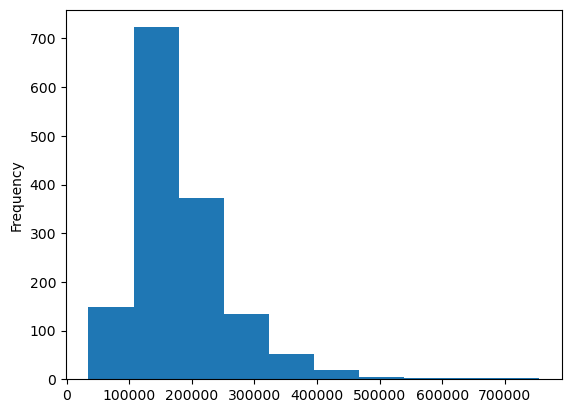

In [9]:
df['SalePrice'].plot.hist()

In [10]:
dep_var = 'SalePrice'

In [11]:
df[dep_var] = np.log(df[dep_var])

<Axes: ylabel='Frequency'>

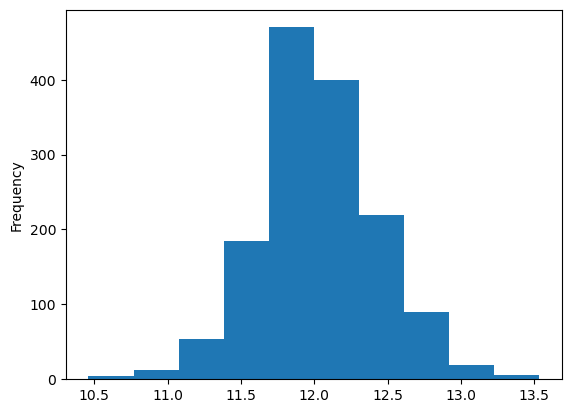

In [12]:
df['SalePrice'].plot.hist()

Now to classify each independant variable.

Combing through the [data description](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data), I notice that some columns contain ordinal variables that use a similar rating scale.

In [13]:
rating = 'Ex','Gd','TA','Fa','Po','NA'

In [14]:
df['ExterQual'] = df['ExterQual'].astype('category')
df['ExterQual'].cat.set_categories(rating, ordered=True)

0       Gd
1       TA
2       Gd
3       TA
4       Gd
        ..
1455    TA
1456    TA
1457    Ex
1458    TA
1459    Gd
Name: ExterQual, Length: 1460, dtype: category
Categories (6, object): ['Ex' < 'Gd' < 'TA' < 'Fa' < 'Po' < 'NA']

In [15]:
ordrating_vars = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 
                 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']

for i in ordrating_vars:
    df[i] = df[i].astype('category')
    df[i].cat.set_categories(rating, ordered=True, inplace=True)

/var/folders/_d/n0whzm9s1_z4n7yzjrywm1880000gn/T/ipykernel_28253/1229790691.py:6: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  df[i].cat.set_categories(rating, ordered=True, inplace=True)
/var/folders/_d/n0whzm9s1_z4n7yzjrywm1880000gn/T/ipykernel_28253/1229790691.py:6: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  df[i].cat.set_categories(rating, ordered=True, inplace=True)
/var/folders/_d/n0whzm9s1_z4n7yzjrywm1880000gn/T/ipykernel_28253/1229790691.py:6: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  df[i].cat.set_cat

There is also `Functional`, `BsmtFinType1`, `BsmtExposure` that look like ordinal variables, but we'll leave them for now. I want to get a Feature Importance plot first before circling back to this.

Now, to transform the Categorical data into numeric representations and deal with the missing fields. 

In [16]:
procs = [Categorify, FillMissing(add_col=False)]
splits = RandomSplitter(valid_pct=0.2)(range_of(df))

cont,cat = cont_cat_split(df, 1, dep_var=dep_var)
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [17]:
len(cont), len(cat)

(37, 43)

#### 5.1 Adjusting the Train dataset to match the Test dataset

Coming back to add in a row with missing fields within the columns that the Test set had contained. I'll start by appending a copy of the first row and then update the fields that should be missing to `False`.
i.e. 'LotFrontage_na',
 'MasVnrArea_na',
 'BsmtFinSF1_na',
 'BsmtFinSF2_na',
 'BsmtUnfSF_na',
 'TotalBsmtSF_na',
 'BsmtFullBath_na',
 'BsmtHalfBath_na',
 'GarageYrBlt_na',
 'GarageCars_na',
 'GarageArea_na'

In [18]:
missing_fields = ['LotFrontage','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF',
          'BsmtFullBath','BsmtHalfBath','GarageYrBlt','GarageCars','GarageArea']

In [19]:
new_row = df[:1]
df2 = df.append([new_row]*len(missing_fields), ignore_index=True)

/var/folders/_d/n0whzm9s1_z4n7yzjrywm1880000gn/T/ipykernel_28253/2342824707.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df.append([new_row]*len(missing_fields), ignore_index=True)


In [20]:
x = 1460
for i in missing_fields:
    df2.loc[x, [i]] = float("nan")
    df2.loc[x, [i]] 
    x+=1
    
df2[missing_fields].tail(11)

,LotFrontage,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,BsmtHalfBath,GarageYrBlt,GarageCars,GarageArea
1460,NaN,196.0,706.0,0.0,...,0.0,2003.0,2.0,548.0
1461,65.0,NaN,706.0,0.0,...,0.0,2003.0,2.0,548.0
1462,65.0,196.0,NaN,0.0,...,0.0,2003.0,2.0,548.0
1463,65.0,196.0,706.0,NaN,...,0.0,2003.0,2.0,548.0
1464,65.0,196.0,706.0,0.0,...,0.0,2003.0,2.0,548.0
1465,65.0,196.0,706.0,0.0,...,0.0,2003.0,2.0,548.0
1466,65.0,196.0,706.0,0.0,...,0.0,2003.0,2.0,548.0
1467,65.0,196.0,706.0,0.0,...,NaN,2003.0,2.0,548.0
1468,65.0,196.0,706.0,0.0,...,0.0,NaN,2.0,548.0
1469,65.0,196.0,706.0,0.0,...,0.0,2003.0,NaN,548.0


In [21]:
dep_var = 'SalePrice'
df2[dep_var] = np.log(df2[dep_var])

In [22]:
for i in ordrating_vars:
    df2[i] = df2[i].astype('category')
    df2[i].cat.set_categories(rating, ordered=True, inplace=True)

/var/folders/_d/n0whzm9s1_z4n7yzjrywm1880000gn/T/ipykernel_28253/964828124.py:3: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  df2[i].cat.set_categories(rating, ordered=True, inplace=True)
/var/folders/_d/n0whzm9s1_z4n7yzjrywm1880000gn/T/ipykernel_28253/964828124.py:3: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  df2[i].cat.set_categories(rating, ordered=True, inplace=True)
/var/folders/_d/n0whzm9s1_z4n7yzjrywm1880000gn/T/ipykernel_28253/964828124.py:3: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  df2[i].cat.set_cat

In [23]:
procs = [Categorify, FillMissing]
splits2 = RandomSplitter(valid_pct=0.2)(range_of(df2))

cont2,cat2 = cont_cat_split(df2, 1, dep_var=dep_var)
#to = TabularPandas(df2, procs, cat2, cont2, y_names=dep_var, splits=splits2)

splits2

((#1177) [1112,276,775,392,1201,477,942,881,812,1325...],
 (#294) [154,546,893,1367,620,1231,914,1034,860,1068...])

In [24]:
to = TabularPandas(df2, procs, cat2, cont2, y_names=dep_var, splits=splits2)

AssertionError: nan values in `BsmtHalfBath` but not in setup training set

In [ ]:
len(cont2), len(cat2)

#### Save to pickle

Ok. Back to the program.

In [ ]:
len(to.train),len(to.valid)

(1168, 292)

In [ ]:
to.show(5)

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
1172,FV,Pave,Pave,IR1,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,TwnhsE,2Story,Gable,CompShg,MetalSd,MetalSd,None,Gd,TA,PConc,Gd,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,#na#,Detchd,Fin,TA,TA,Y,#na#,#na#,#na#,WD,Normal,1173,160,35.0,4017,7,5,2006,2007,0.0,0,0,625,625,625,625,0,1250,0,0,2,1,2,1,5,0,2006.0,2,625,0,54,0,0,0,0,0,3,2008,12.054668
1313,RL,Pave,#na#,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,BuiltIn,Fin,TA,TA,Y,#na#,#na#,#na#,WD,Normal,1314,60,108.0,14774,9,5,1999,1999,165.0,0,0,1393,1393,1422,1177,0,2599,0,0,2,1,4,1,10,1,1999.0,3,779,668,30,0,0,0,0,0,5,2010,12.716402
1327,RL,Pave,#na#,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,Gd,Gd,CBlock,TA,TA,No,ALQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Ex,Attchd,Unf,TA,TA,Y,#na#,MnPrv,#na#,WD,Normal,1328,20,60.0,6600,5,9,1982,2008,0.0,641,0,175,816,816,0,0,816,0,1,1,0,3,1,5,1,1982.0,1,264,0,0,0,0,0,0,0,10,2008,11.779128
29,RM,Pave,#na#,IR1,Lvl,AllPub,Inside,Gtl,BrkSide,Feedr,RRNn,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,BrkTil,TA,TA,No,Unf,Unf,GasA,Fa,N,SBrkr,Fa,Typ,#na#,Detchd,Unf,Fa,TA,Y,#na#,#na#,#na#,WD,Normal,30,30,60.0,6324,4,6,1927,1950,0.0,0,0,520,520,520,0,0,520,0,0,1,0,1,1,4,0,1920.0,1,240,49,0,87,0,0,0,0,5,2008,11.134589
397,RL,Pave,#na#,Reg,Lvl,AllPub,Inside,Gtl,NAmes,PosN,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,TA,TA,CBlock,TA,TA,No,ALQ,Unf,GasA,TA,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,#na#,#na#,#na#,WD,Normal,398,60,69.0,7590,5,5,1962,1962,288.0,540,0,324,864,876,936,0,1812,0,0,2,0,4,1,8,1,1962.0,1,264,0,168,0,0,0,0,0,7,2007,12.040608


In [ ]:
to.items.head(5)

Ok, that worked, we can see the numeric represented variables in the `.items` table.

Now to save it into a Pickle file. So we can skip this part the next time we run the notebook.

In [ ]:
save_pickle(path/'to.pkl',to)

In [ ]:
to = load_pickle(path/'to.pkl')

In [29]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

### 3. Decision Tree

Alright, we are ready to try things out with a decision tree.

In [ ]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);

In [ ]:
draw_tree(m, xs, size=10, leaves_parallel=True, precision=2)

In [ ]:
viz_model = dtreeviz.model(m, xs, y, feature_names=xs.columns)
viz_model.view(orientation='LR', scale=1.50)

In [33]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [ ]:
m = DecisionTreeRegressor(max_leaf_nodes=5)
m.fit(xs, y);

In [ ]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y), m.get_n_leaves()

In [ ]:
m = DecisionTreeRegressor(min_samples_leaf=10)
m.fit(xs, y);

In [ ]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y), m.get_n_leaves()

### 4. Random Forest time

In [26]:
round(math.sqrt(1459))

38

In [30]:
random.seed(42)

def rf(xs, y, n_estimators=1000, max_samples=round(1459*.8),
       max_features=0.3, min_samples_leaf=2, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
                                  max_samples=max_samples, max_features=max_features,
                                  min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [31]:
m = rf(xs, y);

In [34]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.066701, 0.121985)

In [35]:
preds = np.stack([t.predict(valid_xs.values) for t in m.estimators_])

In [36]:
preds.shape

(1000, 292)

In [37]:
r_mse(preds.mean(0), valid_y)

0.121985

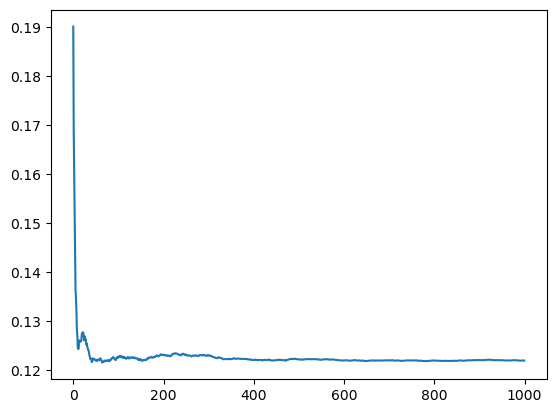

In [38]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(m.n_estimators)])

In [39]:
m = rf(xs, y, n_estimators=100);

In [40]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.067469, 0.124473)

### Feature Importance

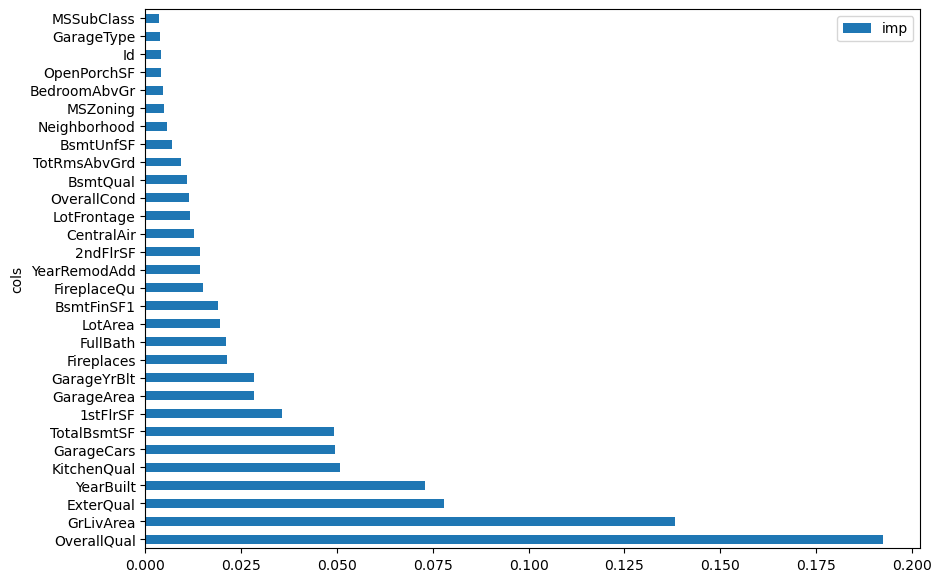

In [41]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

fi = rf_feat_importance(m, xs)
fi[:10]

def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(10,7))

plot_fi(fi[:30]);

### Reducing Features - Cutting out the fat

In [ ]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep), len(fi)

In [ ]:
to_keep

In [ ]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [ ]:
m = rf(xs_imp, y, n_estimators=50);

In [ ]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

In [ ]:
len(xs.columns), len(xs_imp.columns)

In [ ]:
plot_fi(fi[:len(xs_imp.columns)]);

### Partial Dependance Plots

In [ ]:
valid_xs_imp['OverallQual'].value_counts(ascending=True, sort=True).plot.barh()

In [ ]:
valid_xs_imp['GrLivArea'].plot.hist()

In [ ]:
valid_xs_imp['YearBuilt'].plot.hist()

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

fig,ax = plt.subplots(figsize=(12, 4))
PartialDependenceDisplay.from_estimator(m, valid_xs_imp, ['OverallQual','GrLivArea', 'YearBuilt'],
                                       grid_resolution=20, ax=ax)

Now that we've mucked around with the random forests and decision trees, it seems that for a dataset of 1,000 plus rows, the DT is out performing the RF. RF are better if single models suffer from instability. This dataset is reasonably stable.

### 4.1 Gradient Boost

In [ ]:
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

In [ ]:
len(xs), len(y)

(1168, 1168)

In [ ]:
reg = GradientBoostingRegressor(random_state=0)
reg.fit(xs, y)

GradientBoostingRegressor(random_state=0)

In [ ]:
reg = GradientBoostingRegressor(
    loss='squared_error', 
    learning_rate=0.1, 
    n_estimators=100, 
    subsample=1, 
    criterion='friedman_mse', 
    min_samples_split=2, 
    min_samples_leaf=1, 
    min_weight_fraction_leaf=0.0, 
    max_depth=3, 
    min_impurity_decrease=0.0, 
    init=None, 
    random_state=None, 
    max_features=None, 
    alpha=0.9, 
    verbose=0, 
    max_leaf_nodes=None, 
    warm_start=False, 
    validation_fraction=0.1, 
    n_iter_no_change=None, 
    tol=0.0001, 
    ccp_alpha=0.0)
reg.fit(xs, y)

GradientBoostingRegressor(subsample=1)

In [ ]:
reg.score(valid_xs, valid_y)

0.9110905653718209

In [ ]:
m_rmse(reg, xs, y), m_rmse(reg, valid_xs, valid_y)

(0.078152, 0.116549)

In [ ]:
reg.predict(valid_xs)

In [ ]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [ ]:
r_mse(ensemble(xs), y), r_mse(ensemble(valid_xs), valid_y)

(0.033695, 0.115806)

#### "Ensembling" RF and GB models

In [ ]:
rfpred = m.predict(xs)
gbpred = reg.predict(xs)

enpred = (rfpred+gbpred)/2

In [ ]:
enpred.shape

(1168,)

In [ ]:
def ensemble(xs):
    rfpred = m.predict(xs)
#    gbpred = reg.predict(xs)
    xgpred = bst.predict(xs)
    return (rfpred + xgpred)/2

### 4.2 XGBoost

In [ ]:
from xgboost import XGBRegressor

bst = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
bst.fit(xs, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [ ]:
m_rmse(bst, xs, y), m_rmse(bst, valid_xs, valid_y)

(0.000462, 0.117309)

### 4.3 Neural Networks

In [ ]:
splits = RandomSplitter()(df)

In [ ]:
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)

In [ ]:
dls = TabularPandas(
    df, splits=splits,
    procs = [Categorify, FillMissing(add_col=False), Normalize],
    cat_names = cat,
    cont_names = cont,
    y_names = 'SalePrice',
    y_block = RegressionBlock(),
).dataloaders(path='.')

In [ ]:
learn = tabular_learner(dls, metrics=accuracy, layers=[10,20])

SuggestedLRs(slide=0.00013182566908653826, valley=0.010964781977236271)

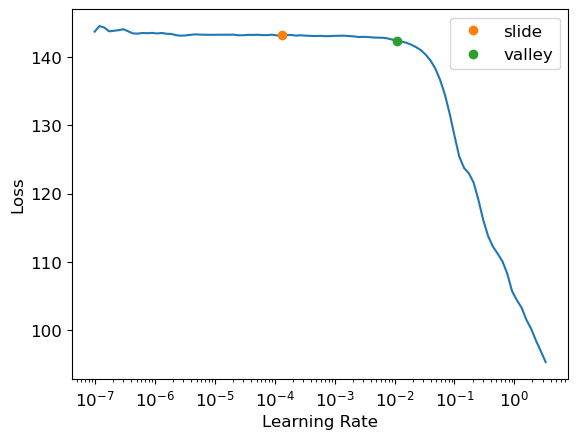

In [ ]:
learn.lr_find(suggest_funcs=(slide,valley))

In [ ]:
learn.fit(10, lr=0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.029836,0.057851,0.000000,00:00
1,0.034424,0.042348,0.000000,00:00
2,0.033955,0.042968,0.000000,00:00
3,0.031956,0.029356,0.000000,00:00
4,0.034643,0.052378,0.000000,00:00
5,0.033414,0.035224,0.000000,00:00
6,0.033418,0.038889,0.000000,00:00
7,0.032412,0.032086,0.000000,00:00
8,0.033846,0.094005,0.000000,00:00
9,0.032285,0.024471,0.000000,00:00


In [ ]:
type(test_to)

fastai.tabular.core.TabularPandas

In [ ]:
test_df = test_df.fillna(0)

In [ ]:
test_dl = learn.dls.test_dl(test_df)

In [ ]:
preds,_ = learn.get_preds(dl=test_dl)

In [ ]:
test_df['SalePrice'] = np.exp(preds)
sub_df = test_df[['Id', 'SalePrice']]
sub_df.to_csv('sub-NN1.csv', index=False)

### 5. Submit to Kaggle!

So, let's try and submit our first decision tree results to kaggle. 

Start by pre-processing the Test set.

In [ ]:
test_df = pd.read_csv(path/'test.csv', low_memory=False)

In [ ]:
ordrating_vars = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 
                 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']

for i in ordrating_vars:
    test_df[i] = test_df[i].astype('category')
    test_df[i].cat.set_categories(rating, ordered=True, inplace=True)

In [ ]:
procs = [Categorify, FillMissing(add_col=False)]

test_cont,test_cat = cont_cat_split(test_df, max_card=1)
test_to = TabularPandas(test_df, procs, cat, cont, y_names=None)
len(test_cont), len(test_cat)

(37, 43)

In [ ]:
test_xs = test_df[cont+cat]

In [ ]:
test_xs

,Id,MSSubClass,LotFrontage,LotArea,...,Fence,MiscFeature,SaleType,SaleCondition
0,1461,20,80.0,11622,...,MnPrv,NaN,WD,Normal
1,1462,20,81.0,14267,...,NaN,Gar2,WD,Normal
2,1463,60,74.0,13830,...,MnPrv,NaN,WD,Normal
3,1464,60,78.0,9978,...,NaN,NaN,WD,Normal
4,1465,120,43.0,5005,...,NaN,NaN,WD,Normal
...,...,...,...,...,...,...,...,...,...
1454,2915,160,21.0,1936,...,NaN,NaN,WD,Normal
1455,2916,160,21.0,1894,...,NaN,NaN,WD,Abnorml
1456,2917,20,160.0,20000,...,NaN,NaN,WD,Abnorml
1457,2918,85,62.0,10441,...,MnPrv,Shed,WD,Normal


In [ ]:
xs

In order for the model to run the prediction the arrangement of the column index has to match the test dataset.

In [ ]:
m.feature_names_in_

In [ ]:
test_df = test_df.reindex(columns=m.feature_names_in_)
test_df.columns

In [ ]:
test_xs = test_to[cat+cont]

In [ ]:
m.predict(test_xs)

In [ ]:
ensemble(test_xs)

array([11.72888376, 11.90723935, 12.12051773, ..., 11.94534964, 11.6349335 , 12.42628553])

In [ ]:
reg.predict(test_xs)

array([11.71440783, 11.91044167, 12.11644081, ..., 11.90498294, 11.65413   , 12.42922336])

Now to create a submission file

In [ ]:
def submit(preds, suff):
    test_df['SalePrice'] = np.exp(preds)
    sub_df = test_df[['Id', 'SalePrice']]
    sub_df.to_csv(f'sub-{suff}.csv', index=False)

In [ ]:
submit(m.predict(test_xs), 'RF4')

In [ ]:
submit(reg.predict(test_xs), 'GB4')

In [ ]:
submit(bst.predict(test_xs), 'XG3')

In [ ]:
submit(ensemble(test_xs), 'EN4')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC